In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("data/train.csv").drop("id", axis=1)
df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [3]:
df["temp_of_extremities"] = df["temp_of_extremities"].map(
    {"cold": 0, "cool": 1, "normal": 2, "warm": 3}
)
df["peripheral_pulse"] = df["peripheral_pulse"].map(
    {"absent": 0, "reduced": 1, "normal": 2, "increased": 3}
)
df["capillary_refill_time"] = df["capillary_refill_time"].map(
    {"less_3_sec": 0, "3": 2, "more_3_sec": 3}
)


df["peristalsis"] = df["peristalsis"].map(
    {"distend_small": 0, "absent": 0, "hypomotile": 1, "normal": 2, "hypermotile": 3}
)

df["abdominal_distention"] = df["abdominal_distention"].map(
    {"none": 0, "slight": 1, "moderate": 2, "severe": 3}
)


df["nasogastric_tube"] = df["nasogastric_tube"].map(
    {"none": 0, "slight": 1, "significant": 2}
)

df["nasogastric_reflux"] = df["nasogastric_reflux"].map(
    {"none": 0, "slight": 0, "less_1_liter": 1, "more_1_liter": 2}
)

df["rectal_exam_feces"] = df["rectal_exam_feces"].map(
    {"absent": 0, "serosanguious": 0, "decreased": 1, "normal": 2, "increased": 3}
)


for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

df["total_protein_ge40"] = df["total_protein"].apply(lambda x: 1 if x > 40 else 0)
df["deviation_from_normal_temp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))

# df['randNumCol'] = np.random.randint(1, 6, df.shape[0])

# df.drop(
#     ["age", "lesion_2", "lesion_3", "cp_data", "surgical_lesion"],
#     axis=1,
#     inplace=True,
# )

df.drop(
    ["lesion_2", "lesion_3"],
    axis=1,
    inplace=True,
)
X = df.drop("outcome", axis=1)

In [4]:
y = df["outcome"]
# le = LabelEncoder()
# y = le.fit_transform(y)

In [5]:
numerical_features = [
    "rectal_temp",
    "pulse",
    "respiratory_rate",
    "nasogastric_reflux_ph",
    "packed_cell_volume",
    "total_protein",
    "abdomo_protein",
    "lesion_1",
    "lesion_2",
    "lesion_3",
    "temp_of_extremities",
    "peripheral_pulse",
    "capillary_refill_time",
    "peristalsis",
    "abdominal_distention",
    "nasogastric_tube",
    "nasogastric_reflux",
    "rectal_exam_feces",
    "total_protein_ge40",
    "deviation_from_normal_temp"
]
categorical_features = X.columns.difference(numerical_features).to_list()


In [9]:
import optuna
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 5),
    }

    model = CatBoostClassifier(
        **params,
        loss_function="MultiClass",
        silent=True,
        thread_count=-1,
        eval_metric="Accuracy",
        early_stopping_rounds=50
    )
    model.fit(X_train, y_train, cat_features=categorical_features)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    return acc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)


In [6]:
model = CatBoostClassifier(
    loss_function="MultiClass",
    verbose=True,
    thread_count=-1,
    eval_metric="Accuracy",
    early_stopping_rounds=30,
    cat_features=categorical_features,
)
params = {
    "min_data_in_leaf": [1, 15, 30, 50, 100],
    "depth": [1, 3, 5, 7, 9, 11],
    "l2_leaf_reg": [0.5, 1, 3, 5],
    "iterations": [500, 1000]
    # "iterations": 883,
}
best_params = model.grid_search(param_grid=params, X=X, y=y, stratified=True)

0:	learn: 0.5668016	test: 0.5384615	best: 0.5384615 (0)	total: 48.8ms	remaining: 24.4s
1:	learn: 0.5617409	test: 0.5384615	best: 0.5384615 (0)	total: 50.1ms	remaining: 12.5s
2:	learn: 0.5617409	test: 0.5384615	best: 0.5384615 (0)	total: 52.4ms	remaining: 8.69s
3:	learn: 0.5627530	test: 0.5384615	best: 0.5384615 (0)	total: 54ms	remaining: 6.7s
4:	learn: 0.5617409	test: 0.5384615	best: 0.5384615 (0)	total: 55.3ms	remaining: 5.47s
5:	learn: 0.5829960	test: 0.5546559	best: 0.5546559 (5)	total: 56.7ms	remaining: 4.67s
6:	learn: 0.5819838	test: 0.5546559	best: 0.5546559 (5)	total: 57.7ms	remaining: 4.06s
7:	learn: 0.5637652	test: 0.5384615	best: 0.5546559 (5)	total: 59.5ms	remaining: 3.66s
8:	learn: 0.5829960	test: 0.5546559	best: 0.5546559 (5)	total: 60.4ms	remaining: 3.3s
9:	learn: 0.6305668	test: 0.6153846	best: 0.6153846 (9)	total: 61.9ms	remaining: 3.03s
10:	learn: 0.5819838	test: 0.5546559	best: 0.6153846 (9)	total: 63.5ms	remaining: 2.82s
11:	learn: 0.5809717	test: 0.5546559	best: 0.6

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

model = CatBoostClassifier(
    **{'min_data_in_leaf': 1, 'depth': 11, 'l2_leaf_reg': 5},
    loss_function="MultiClass",
    verbose=True,
    thread_count=-1,
    eval_metric="Accuracy",
    early_stopping_rounds=30,
    cat_features=categorical_features,
)
model.fit(X, y, cat_features=categorical_features)


0:	learn: 0.7149798	total: 128ms	remaining: 1m 4s
1:	learn: 0.6574899	total: 131ms	remaining: 32.7s
2:	learn: 0.6712551	total: 208ms	remaining: 34.4s
3:	learn: 0.6898785	total: 286ms	remaining: 35.4s
4:	learn: 0.6801619	total: 291ms	remaining: 28.8s
5:	learn: 0.6866397	total: 352ms	remaining: 29s
6:	learn: 0.6939271	total: 417ms	remaining: 29.3s
7:	learn: 0.6955466	total: 466ms	remaining: 28.7s
8:	learn: 0.6963563	total: 526ms	remaining: 28.7s
9:	learn: 0.7044534	total: 592ms	remaining: 29s
10:	learn: 0.7093117	total: 657ms	remaining: 29.2s
11:	learn: 0.7165992	total: 735ms	remaining: 29.9s
12:	learn: 0.7133603	total: 748ms	remaining: 28s
13:	learn: 0.7093117	total: 751ms	remaining: 26.1s
14:	learn: 0.7093117	total: 825ms	remaining: 26.7s
15:	learn: 0.7182186	total: 896ms	remaining: 27.1s
16:	learn: 0.7157895	total: 965ms	remaining: 27.4s
17:	learn: 0.7238866	total: 1.03s	remaining: 27.6s
18:	learn: 0.7246964	total: 1.09s	remaining: 27.6s
19:	learn: 0.7271255	total: 1.15s	remaining: 27

In [24]:
pred = model.predict(X_test)
accuracy_score(y_test, pred)

0.6720647773279352

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 20)


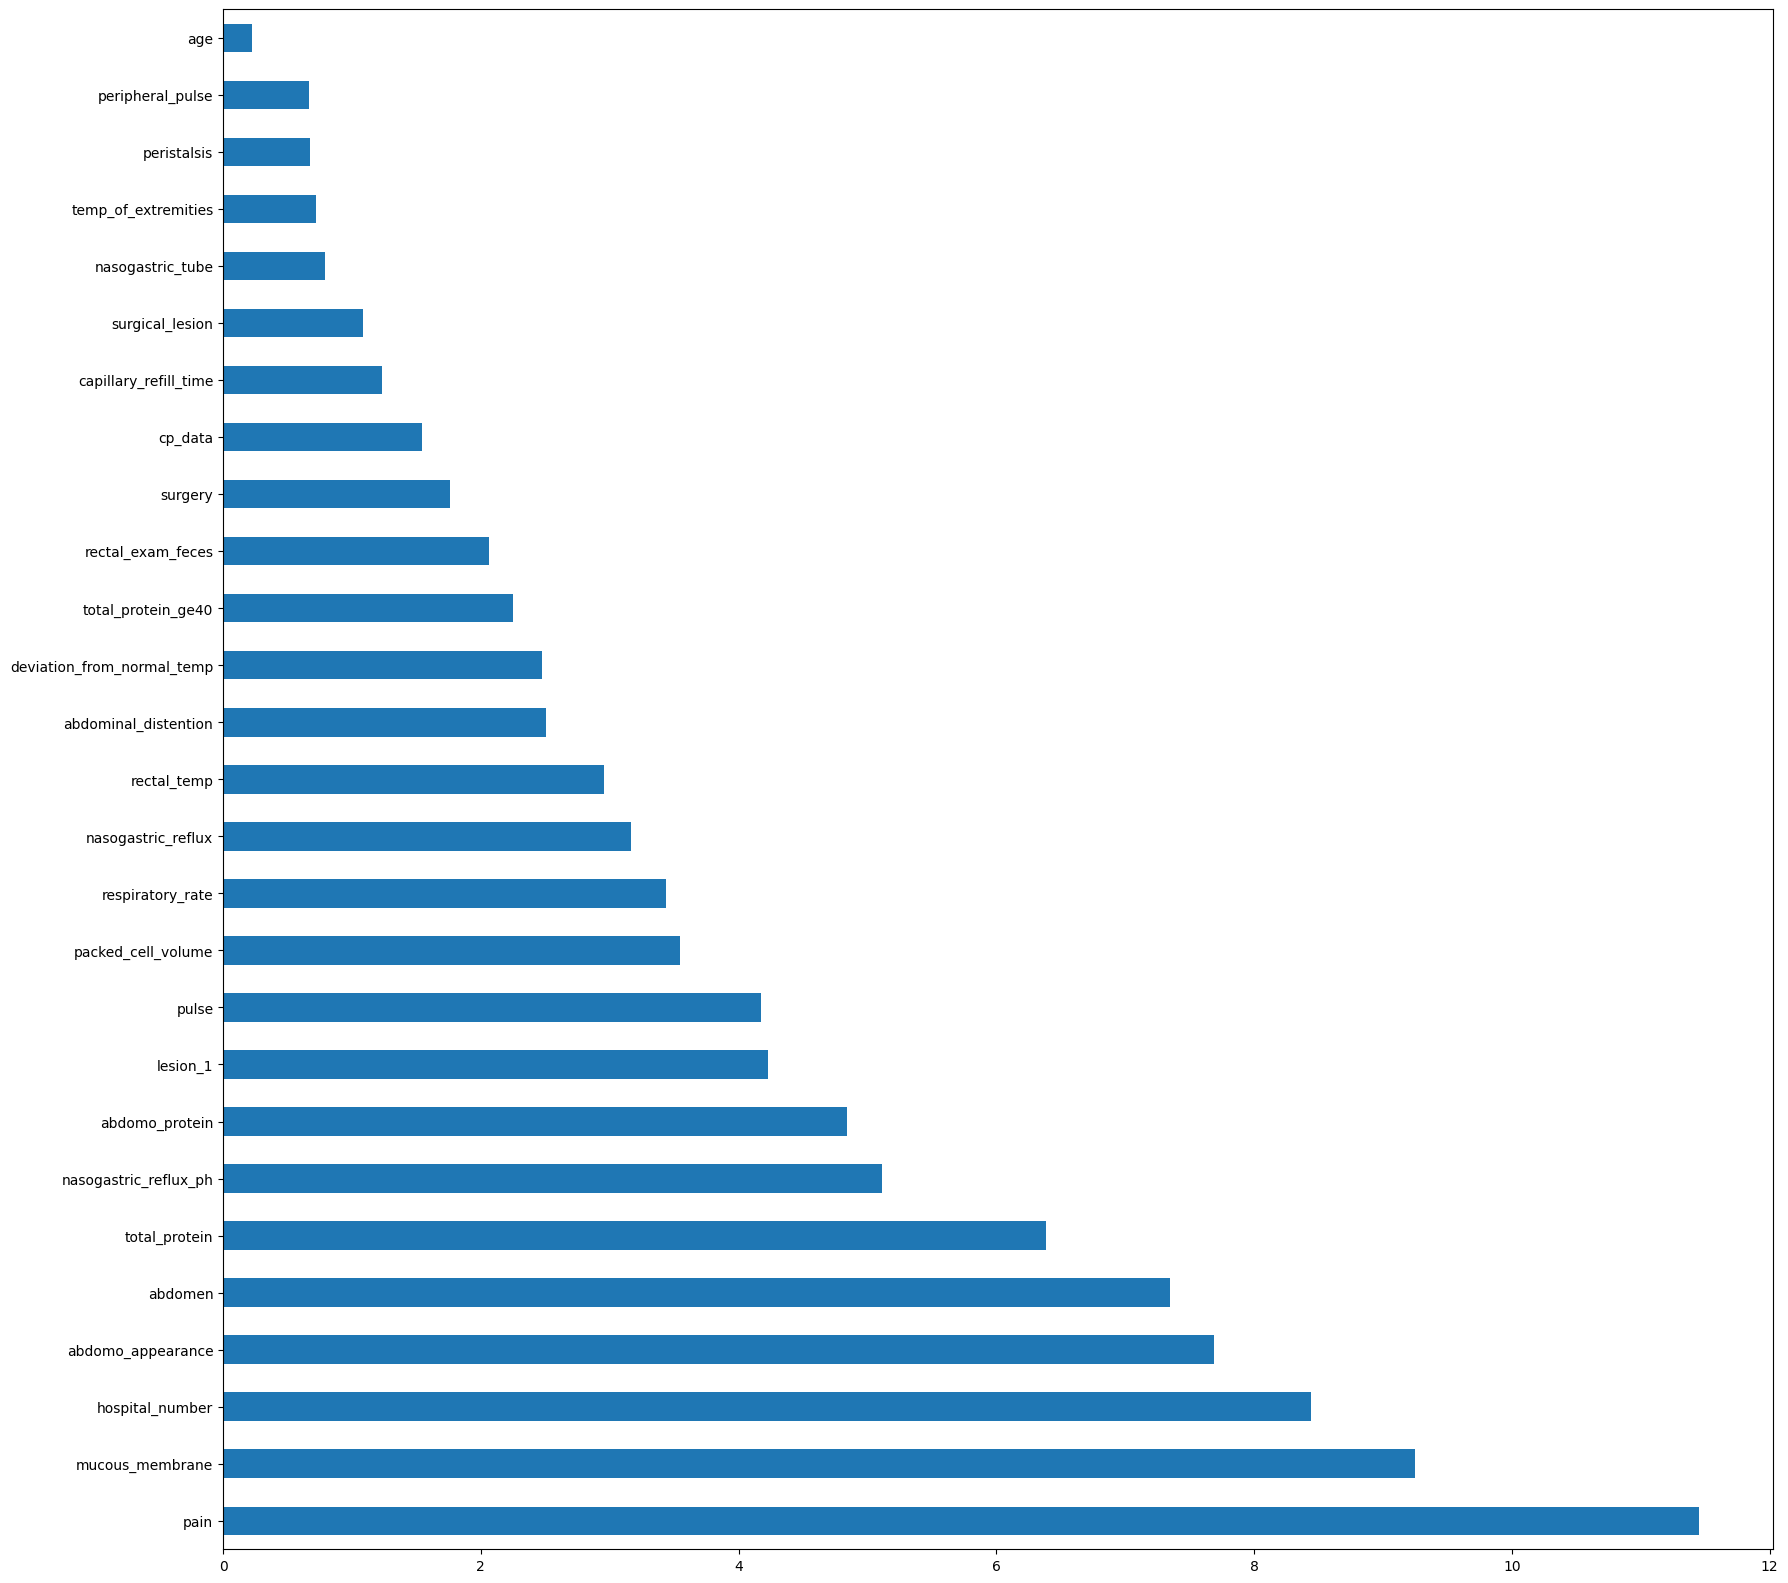

In [8]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(60).plot(kind="barh")
plt.show()


In [9]:
df = pd.read_csv("data/test.csv").drop("id", axis=1)
ids = pd.read_csv("data/test.csv")["id"]


In [10]:
df["temp_of_extremities"] = df["temp_of_extremities"].map(
    {"cold": 0, "cool": 1, "normal": 2, "warm": 3}
)
df["peripheral_pulse"] = df["peripheral_pulse"].map(
    {"absent": 0, "reduced": 1, "normal": 2, "increased": 3}
)
df["capillary_refill_time"] = df["capillary_refill_time"].map(
    {"less_3_sec": 0, "3": 2, "more_3_sec": 3}
)


df["peristalsis"] = df["peristalsis"].map(
    {"distend_small": 0, "absent": 0, "hypomotile": 1, "normal": 2, "hypermotile": 3}
)

df["abdominal_distention"] = df["abdominal_distention"].map(
    {"none": 0, "slight": 1, "moderate": 2, "severe": 3}
)


df["nasogastric_tube"] = df["nasogastric_tube"].map(
    {"none": 0, "slight": 1, "significant": 2}
)

df["nasogastric_reflux"] = df["nasogastric_reflux"].map(
    {"none": 0, "slight": 0, "less_1_liter": 1, "more_1_liter": 2}
)

df["rectal_exam_feces"] = df["rectal_exam_feces"].map(
    {"absent": 0, "serosanguious": 0, "decreased": 1, "normal": 2, "increased": 3}
)


for column in df.columns:
    if column != "outcome":
        df[column].fillna(df[column].mode()[0], inplace=True)

df["total_protein_ge40"] = df["total_protein"].apply(lambda x: 1 if x > 40 else 0)
df["deviation_from_normal_temp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))

df.drop(
    ["lesion_2", "lesion_3"],
    axis=1,
    inplace=True,
)

In [11]:
pred = model.predict(df)


In [12]:
answer = pd.DataFrame({"id": ids.values, "prognosis": pred.T[0]})
answer.to_csv("finalx^3.csv", index=False)


In [30]:
answer["prognosis"].value_counts()

prognosis
lived         358
died          345
euthanized    121
Name: count, dtype: int64